In [3]:
# Training Energy-based Models
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

In [303]:
def gauss_data(N=1000):
    # two gaussians
    g1 = np.random.randn(int(N/2), 2)*0.3 + np.array([0,2])
    g2 = np.random.randn(int(N/2), 2)*0.1 + np.array([2,0])
    return np.r_[g1, g2]
    #return np.random.randn(int(N/2), 2) + np.array([2,2])
    
def scale_gauss(N=1000, dim=2, s=1, t=0):
    g1 = np.random.randn(N, dim)*s+t
    g2 = np.random.randn(N, dim)*s-t

    return np.r_[g1, g2]

def pinwheel_data(N=10000, radial_std=.3, tangential_std=.05, num_classes=4, rate=0.25, norm_data=None):
    n=N
    num_per_class = int(n/num_classes)
    assert n%num_classes == 0
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)
    features = np.random.randn(num_classes*num_per_class, 2) * np.array([radial_std, tangential_std])
    features[:,0]+=1
    labels = np.repeat(np.arange(num_classes), num_per_class)
    
    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1,2,2))
    
    data = np.random.permutation(np.einsum('ti,tij->tj', features, rotations))
    
    # normalize data to -1, 1
    """
    if norm_data is None:
        minx, maxx, miny, maxy = np.min(data[:,0]), np.max(data[:,0]), np.min(data[:,1]), np.max(data[:,1])
        norm_data = {'minx': minx, 'maxx': maxx, 'miny':miny, 'maxy': maxy}
    else:
        minx, maxx, miny, maxy = norm_data['minx'], norm_data['maxx'], norm_data['miny'], norm_data['maxy']
    data[:,0] = (data[:,0]-minx)/ (maxx-minx)
    data[:,1] = (data[:,1]-miny)/ (maxy-miny)
    data = 2*data - 1.0
    """
    data = data + np.array([1,0])
    return data 

get_data = lambda N: scale_gauss(N, dim=4, s=0.4, t=1)

def plot_data(X, title=None):
    if title:
        plt.title(title)
    plt.scatter(X[:,0], X[:,1])
    plt.show()
    
#plot_data(get_data())

In [344]:
def linear(X, dout, name, bias=True, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        dX = int(X.get_shape()[-1])
        W = tf.get_variable('W', shape=(dX, dout))
        if bias:
            b = tf.get_variable('b', initializer=tf.constant(np.zeros(dout).astype(np.float32)))
        else:
            b = 0
    return tf.matmul(X, 0.1*W)+b

def relu_layer(X, dout, name, reuse=False):
    return tf.nn.relu(linear(X, dout, name, reuse=reuse))


def splitX(X, d, flip=False):
    if flip:
        xd = X[:, d:]
        xD = X[:, :d]
    else:
        xd = X[:, :d]
        xD = X[:, d:]
    return xd, xD

def relu_net(x, name, reuse=False, layers=2, dout=1, d_hidden=32, last_layer_bias=True):
    out = x
    with tf.variable_scope(name, reuse=reuse):
        for i in range(layers):
            out = relu_layer(out, dout=d_hidden, name='l%d'%i)
        out = linear(out, dout=dout, name='lfinal', bias=last_layer_bias)
    return out


class NVPLayer(object):
    COUNT = 0
    def __init__(self):
        self.layer_id = NVPLayer.COUNT
        NVPLayer.COUNT += 1
    def forward(self, x, reuse=False):
        raise NotImplementedError()
    
    def inverse(self, z, reuse=False):
        raise NotImplementedError()
    
    def log_det_jac(self, x, reuse=False):
        raise NotImplementedError()


class CouplingLayer(NVPLayer):
    def __init__(self, Xdim, transf=linear, name=None):
        super(CouplingLayer, self).__init__()
        self.d = int(Xdim/2)
        self.D = Xdim-self.d
        self.transf = transf
        if name is None:
            name = 'coup_%d' % self.layer_id
        self.name = name
    
    def forward(self, X, reuse=False):
        xd, xD = X[:, :self.d], X[:, self.d:]
        s = tf.exp(self.transf(xd, dout=self.D, name=self.name+'_scale', reuse=reuse))
        t = self.transf(xd, dout=self.D, name=self.name+'_trans', reuse=reuse)  
        return tf.concat([xd, xD*s + t], axis=1)
        
    def inverse(self, Z, reuse=False):
        xd, xD = Z[:, :self.d], Z[:, self.d:]
        s = tf.exp(-self.transf(xd, dout=self.D, name=self.name+'_scale', reuse=reuse))
        t = self.transf(xd, dout=self.D, name=self.name+'_trans', reuse=reuse)  
        return tf.concat([xd, (xD-t)*s], axis=1)
    
    def log_det_jac(self, X, reuse=False):
        xd, xD = X[:, :self.d], X[:, self.d:]
        s = self.transf(xd, dout=self.D, name=self.name+'_scale', reuse=reuse)
        return tf.reduce_sum(s, axis=1)
    

class FlipLayer(NVPLayer):
    def __init__(self, Xdim):
        super(FlipLayer, self).__init__()
        self.d = int(Xdim/2)
        self.D = Xdim-self.d
        
    def forward(self, X, reuse=False):
        xd, xD = X[:, :self.d], X[:, self.d:]
        return tf.concat([xD, xd], axis=1)
        
    def inverse(self, Z, reuse=False):
        #return self.forward(Z)
        xd, xD = Z[:, :self.d], Z[:, self.d:]
        return tf.concat([xD, xd], axis=1)
    
    def log_det_jac(self, x, reuse=False):
        return 0.0
    

class NVPNetwork(object):
    def __init__(self):
        self.layers = []
        
    def __rshift__(self, layer):
        self.add_layer(layer)
        return self
    
    def add_layer(self, layer):
        self.layers.append(layer)

    def forward_and_jac(self, X):
        out = X
        total_logdet = 0
        for l in self.layers:
            nout = l.forward(out, reuse=False)
            ldj = l.log_det_jac(out, reuse=True)
            total_logdet += ldj
            out = nout
        return out, total_logdet
    
    def inverse(self, Z):
        inp = Z
        for i in range(len(self.layers)-1, -1, -1):
            inp = self.layers[i].inverse(inp, reuse=True)
        return inp
        

def unit_gauss_log_pdf(X):
    dX = int(X.get_shape()[1])
    lpdf = -(dX/2.0)*np.log(2*np.pi) - 0.5*tf.reduce_sum(X*X, axis=1)
    return lpdf

In [345]:
class RealNVPModel(object):
    def __init__(self, dX=2):
        self.dX = dX
        with tf.variable_scope('model'):
            self.X = tf.placeholder(tf.float32, [None, dX], name='x')
            self.Z = tf.placeholder(tf.float32, [None, dX], name='z')

            self.lr = tf.placeholder(tf.float32, (), name='lr')
            
            flip = False
            #fX = coupling_layer_fwd(self.X, name='l1', flip=flip)
            #logdetjac = coupling_layer_logdetjac(self.X, name='l1', reuse=True, flip=flip)
            #fZ = coupling_layer_inv(self.Z, name='l1', reuse=True, flip=flip)
            nvpnet = NVPNetwork() >> \
                CouplingLayer(dX, transf=relu_net) >> FlipLayer(dX) >>  \
                CouplingLayer(dX, transf=relu_net) >> FlipLayer(dX) >>  \
                CouplingLayer(dX) >> FlipLayer(dX) >>\
                CouplingLayer(dX)
                
            fX, logdetjac = nvpnet.forward_and_jac(self.X)
            fZ = nvpnet.inverse(self.Z)
            
            
            self.fZ = fZ
            self.fX = fX
            #logdetjac = logdetjac
            logZ = unit_gauss_log_pdf(fX)
            self.logZ = tf.reduce_mean(logZ)
            self.logdetjac = tf.reduce_mean(logdetjac)
            self.loss = - tf.reduce_mean(logZ + logdetjac)
            self.train_step = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
    
    def fit(self, data, itrs=100, batch_size=128):
        N = data.shape[0]
        for i in range(itrs):
            # sample
            idx = np.random.randint(0, N, size=batch_size)
            batch_data = data[idx]
            loss = self._step(batch_data)
            
            if i%1000== 0:
                print('Itr %d loss: %.3f' % (i, loss))
                fX, lz, lj = tf.get_default_session().run([self.fX, self.logZ, self.logdetjac], feed_dict={self.X: data})
                print('\tmu: %s' % (np.mean(fX, axis=0)))
                print('\tcov: %s' % np.cov(fX.T))
                print('\tlogZ: %.3f' % lz)
                print('\tlogJac: %.3f' % lj)

    def _step(self, batch):
        loss, _ = tf.get_default_session().run([self.loss, self.train_step], feed_dict={self.X: batch,
                                                   self.lr: 1e-3})
        return loss
    
    def fwd_map(self, X):
        return  tf.get_default_session().run(self.fX, feed_dict={self.X: X})
    
    def inv_map(self, Z):
        return  tf.get_default_session().run(self.fZ, feed_dict={self.Z: Z})
    
    def sample(self, N=100):
        samples = np.random.randn(N, self.dX)
        return tf.get_default_session().run(self.fZ, feed_dict={self.Z: samples})
    

In [ ]:
tf.reset_default_graph()
sess = tf.Session()
model = RealNVPModel(dX=4)

with sess.as_default():
    sess.run(tf.global_variables_initializer())
    data = get_data(N=5000)
    model.fit(data, itrs=12000)

Itr 0 loss: 5.717
	mu: [ 0.00495182 -0.16702256 -0.01085052  0.08366806]
	cov: [[ 0.83373491  0.85768817  0.80923017  0.65884782]
 [ 0.85768817  1.27862378  1.08921654  0.87347961]
 [ 0.80923017  1.08921654  1.20900192  0.8582776 ]
 [ 0.65884782  0.87347961  0.8582776   0.86477186]]
	logZ: -5.786
	logJac: -0.009
Itr 1000 loss: 3.335
	mu: [ 0.0213995  -0.02351674  0.02093395  0.02194505]
	cov: [[ 1.10769501  0.27409239  0.04407547  0.00918429]
 [ 0.27409239  0.91269523 -0.03354154 -0.14714352]
 [ 0.04407547 -0.03354154  0.99024595  0.2183961 ]
 [ 0.00918429 -0.14714352  0.2183961   0.98493769]]
	logZ: -5.674
	logJac: 2.453
Itr 2000 loss: 3.022
	mu: [-0.00718361 -0.01448999 -0.03881503 -0.024218  ]
	cov: [[ 1.01878795  0.02137623 -0.00184527  0.02630188]
 [ 0.02137623  0.98532009 -0.01829342 -0.0814699 ]
 [-0.00184527 -0.01829342  0.97599586  0.13796142]
 [ 0.02630188 -0.0814699   0.13796142  1.02889348]]
	logZ: -5.681
	logJac: 2.583
Itr 3000 loss: 3.140
	mu: [-0.02187049 -0.00714001  0.

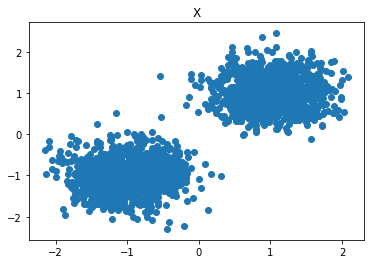

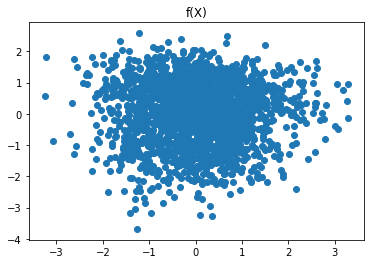

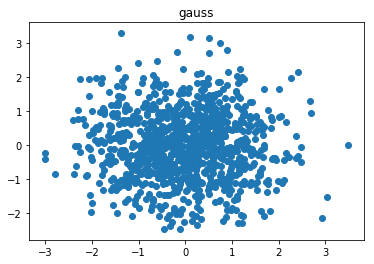

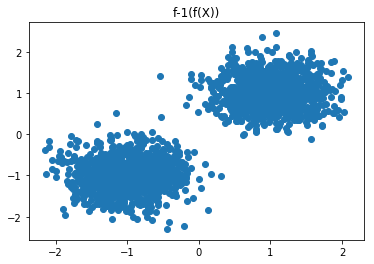

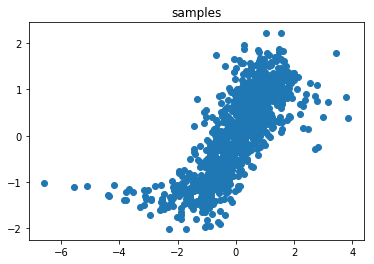

In [338]:
with sess.as_default():
    data = get_data(N=1000)
    plot_data(data, title='X')
    
    Z = model.fwd_map(data)
    plot_data(Z, title='f(X)')
    plot_data(np.random.randn(1000, 2), title='gauss')

    Xhat = model.inv_map(Z)
    plot_data(Xhat, title='f-1(f(X))')
    
    plot_data(model.sample(N=1000), title='samples')